## Neural Style Transfer Practice [TF tutorials](https://www.tensorflow.org/tutorials/generative/style_transfer)

keywords:

1. keras.applications load a pre-trained NN
  - Get specified intermediate layers (by layer name) and freeze them as an extractor
    - pre-trained model having their own [pre-processing](https://medium.com/@sci218mike/%E5%9C%96%E7%89%87%E9%A0%90%E8%99%95%E7%90%86%E4%BD%BF%E7%94%A8keras-applications-%E7%9A%84-preprocess-input-6ef0963a483e)
  - Learn using Keras `Model` [attributes](https://keras.io/models/about-keras-models/) and [methods](https://keras.io/models/model/#get_layer)
  - Learn using Keras [`Layer`](https://keras.io/layers/about-keras-layers/)
2. tf.train.Checkpoint store and reload model
3. learn using `tf.linalg.einsum`

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from pathlib import Path
import cv2

Download model and load it as keras's Model

In [2]:
vggPath = Path('./pretrained_model')
modelname = 'vgg19.ckpt-1'
isDownloaded = True
if len(list(vggPath.glob(modelname+'.index')))==0 or len(list(vggPath.glob(modelname+'.data*')))==0:
    isDownloaded = False

In [3]:
if isDownloaded:
    vgg = tf.keras.applications.VGG19(include_top=False, weights=None)
    checkpoint = tf.train.Checkpoint(vgg19=vgg)
    checkpoint.restore(str(vggPath / modelname))
    print('Restored VGG19')
else:
    vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
    checkpoint = tf.train.Checkpoint(vgg19=vgg)
    checkpoint.save(str(vggPath / modelname))
    print('Downloaded and saved VGG19')

Restored VGG19


Set trainable as False and specifying content and style layers

In [4]:
vgg.trainable = False

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [5]:
layer_names = [layer.name for layer in vgg.layers]
print(layer_names)
print(vgg.get_layer('input_1').input)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


## Create a Content and Style Extractor

Sytle output is the gram matrix of layer's response

<img src="style_loss.png" width=20% height=20% align='left'>

In [6]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [7]:
class StyleContentModel(Model):
    def __init__(self, vgg, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        outputs = [vgg.get_layer(name).output for name in style_layers+content_layers]
        self.extractor = Model([vgg.input], outputs)
        self.extractor.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255.0
        "preprocessed_input expects [0~255] and will substract some mean according to model type"
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.extractor(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

extractor = StyleContentModel(vgg, style_layers, content_layers)

## Load style/content images and extract corresponding target outputs

In [8]:
style_image = plt.imread('images/guernica.jpg')

content_image = plt.imread('images/DSC08803.JPG')

img_w = 800
img_h = 600


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



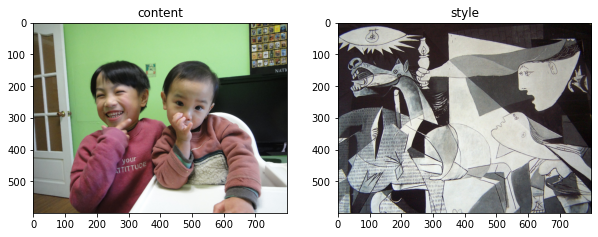

In [9]:
# plot
content_image = cv2.resize(content_image,(img_w,img_h))
content_image = np.reshape(content_image,(1,)+content_image.shape)/255.0

style_image = cv2.resize(style_image,(img_w,img_h))
style_image = np.reshape(style_image,(1,)+style_image.shape)/255.0

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(content_image[0])
plt.title('content')
plt.subplot(1,2,2)
plt.imshow(style_image[0])
plt.title('style')


style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

## Define style content loss
$$
loss = w_\text{style} * \text{MSE}(\text{Gram matrix diff}) + w_\text{style} * \text{MSE}(\text{layer response diff})
$$

In [10]:
style_weight=1
content_weight=1e4
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Define optimizer, training step

In [11]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [12]:
import PIL.Image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## Training where variable image is inited with content image

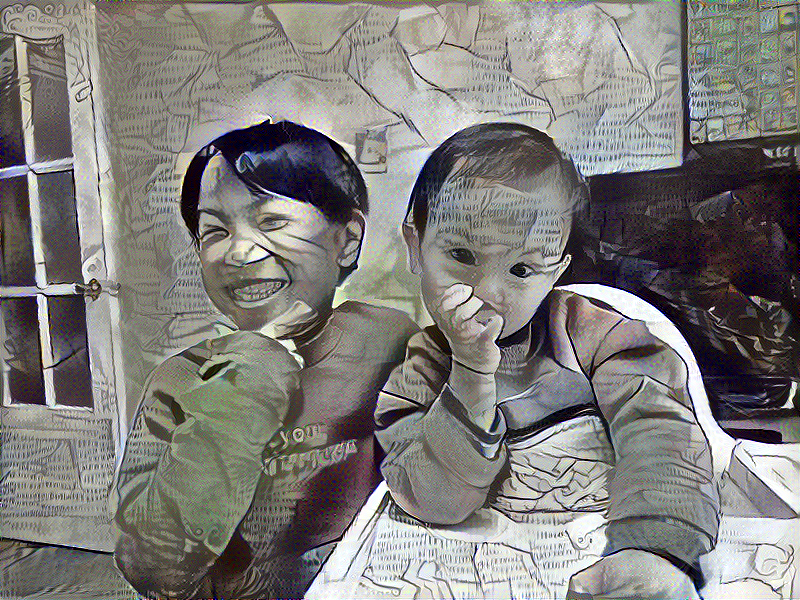

Train step: 1000
Total time: 159.5


In [13]:
import time
import IPython.display as display
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
image = tf.Variable(content_image)
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

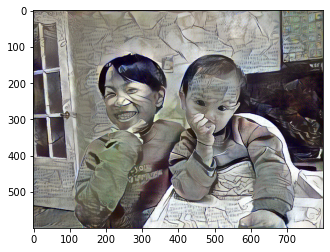

In [14]:
plt.imshow(image.numpy()[0,...])